Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization,MaxPool2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

In [2]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')
#base_skin_dir = os.path.join('https://drive.google.com/drive/folders/10aXMiKzUDHT3UNGootCzRcjv7S1CsWCP?usp=sharing')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("C:\\Users\\kmishra\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train")
data_dir_test = pathlib.Path('C:\\Users\\kmishra\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(data_dir_train, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

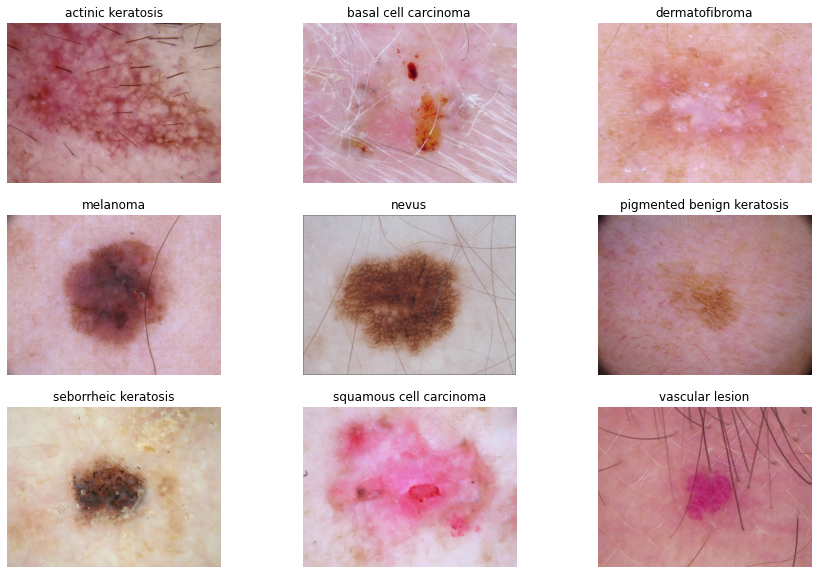

In [9]:
### your code goes here, you can use training or validation data to visualize
import glob
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [10]:
for i, class_ in enumerate(list(class_names)):
    print(i,class_)

0 actinic keratosis
1 basal cell carcinoma
2 dermatofibroma
3 melanoma
4 nevus
5 pigmented benign keratosis
6 seborrheic keratosis
7 squamous cell carcinoma
8 vascular lesion


In [11]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

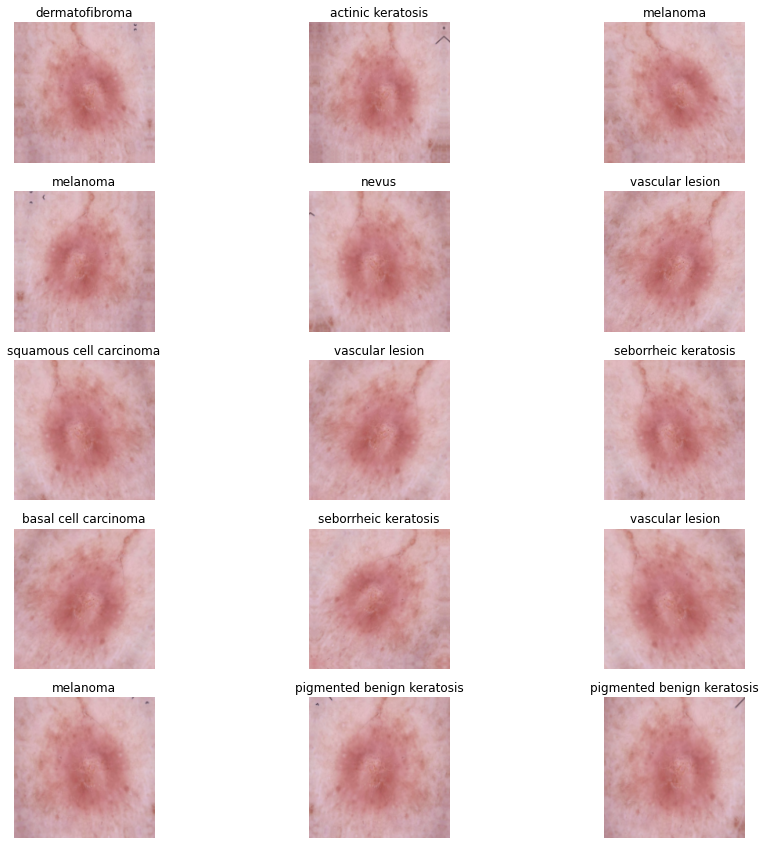

In [13]:

plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 97s 342ms/step - loss: 1.8777 - accuracy: 0.2747 - val_loss: 1.7355 - val_accuracy: 0.3271
Epoch 2/20
281/281 [==============================] - 96s 340ms/step - loss: 1.4776 - accuracy: 0.4305 - val_loss: 1.3899 - val_accuracy: 0.4504
Epoch 3/20
281/281 [==============================] - 96s 342ms/step - loss: 1.3159 - accuracy: 0.4979 - val_loss: 1.2947 - val_accuracy: 0.4976
Epoch 4/20
281/281 [==============================] - 97s 345ms/step - loss: 1.2158 - accuracy: 0.5380 - val_loss: 1.2650 - val_accuracy: 0.5389
Epoch 5/20
281/281 [==============================] - 97s 347ms/step - loss: 1.1492 - accuracy: 0.5593 - val_loss: 1.0906 - val_accuracy: 0.5852
Epoch 6/20
281/281 [==============================] - 96s 343ms/step - loss: 1.0560 - accuracy: 0.6040 - val_loss: 0.9737 - val_accuracy: 0.6417
Epoch 7/20
281/281 [==============================] - 96s 341ms/step - loss: 0.9768 - accuracy: 0.6296 - val_loss: 1.0521 - val_ac

### Visualizing training results

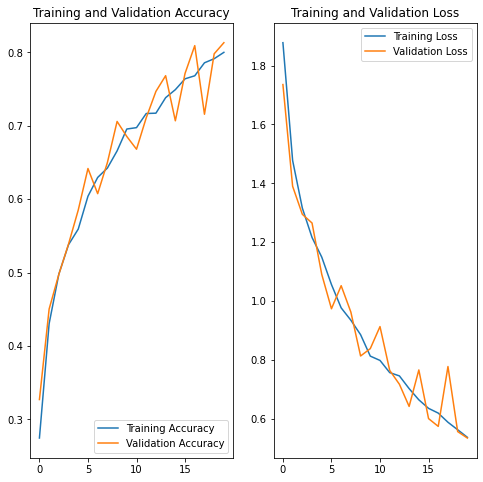

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
As the accuracy is increasing and the loss is decreasing we seeems to be overfitting as the training accuracy is increasing whereas validation accuracy is fluctuating as we move to the top

### Write your findings here

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

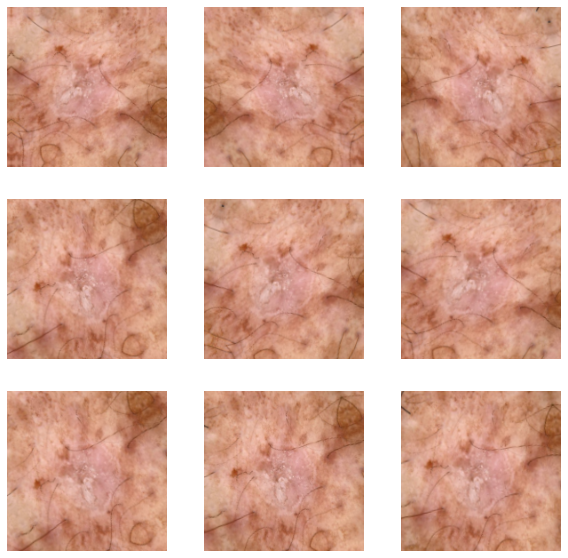

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)## your training code

Epoch 1/20
281/281 [==============================] - 108s 384ms/step - loss: 1.8259 - accuracy: 0.3062 - val_loss: 1.4810 - val_accuracy: 0.4406
Epoch 2/20
281/281 [==============================] - 121s 430ms/step - loss: 1.4325 - accuracy: 0.4527 - val_loss: 1.3555 - val_accuracy: 0.4798
Epoch 3/20
281/281 [==============================] - 122s 433ms/step - loss: 1.2957 - accuracy: 0.5024 - val_loss: 1.3992 - val_accuracy: 0.4842
Epoch 4/20
281/281 [==============================] - 109s 388ms/step - loss: 1.2277 - accuracy: 0.5319 - val_loss: 1.1837 - val_accuracy: 0.5461
Epoch 5/20
281/281 [==============================] - 99s 351ms/step - loss: 1.1638 - accuracy: 0.5591 - val_loss: 1.4137 - val_accuracy: 0.5065
Epoch 6/20
281/281 [==============================] - 96s 343ms/step - loss: 1.1186 - accuracy: 0.5744 - val_loss: 1.1505 - val_accuracy: 0.5621
Epoch 7/20
281/281 [==============================] - 98s 347ms/step - loss: 1.0461 - accuracy: 0.6114 - val_loss: 1.0808 - va

### Visualizing the results

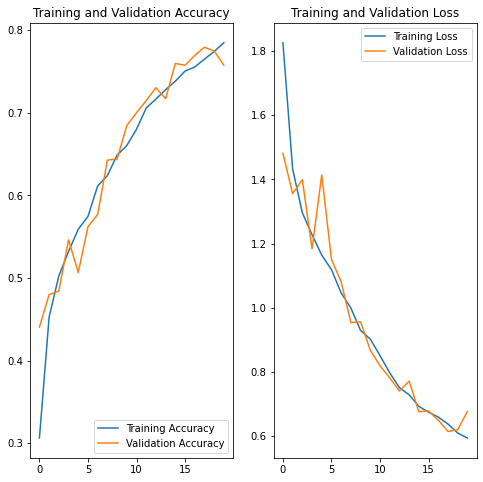

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
Loss is increasing with increasing epoch  where as at the same time training and validation accuracy is also increasing. but we can observe increase in validation loss at the end of the epoch. whereas the accuracy is decreasing at the end as well. Accuracy as well has increased by 10%

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

seborrheic keratosis:77 has the least number of samples


pigmented benign keratosis:462 has the highest number of samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset=("C:/Users/kmishra/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+i,output_directory=('C:/Users/kmishra/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'+i+'/output'))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to C:/Users/kmishra/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E2AC407580>: 100%|██████████| 500/500 [00:06<00:00, 75.94 Samples/s]                   
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E2A88728B0>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to C:/Users/kmishra/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E2AC43D040>: 100%|██████████| 500/500 [00:05<00:00, 84.27 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2E2AC3FA7F0>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to C:/Users/kmishra/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E2AC40DD60>: 100%|██████████| 500/500 [00:06<00:00, 78.30 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to C:/Users/kmishra/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2E2A9CE6B80>: 100%|██████████| 500/500 [00:32<00:00, 15.27 Samples/s]                   
Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x2E2A8872CD0>:   0%|          | 1/500 [00:00<01:03,  7.80 Samples/s]

Initialised with 357 image(s) found.
Output directory set to C:/Users/kmishra/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x2E2AC3BC910>: 100%|██████████| 500/500 [00:27<00:00, 18.02 Samples/s]                    
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E2A9CD4B50>:   1%|          | 6/500 [00:00<00:50,  9.78 Samples/s]                  

Initialised with 462 image(s) found.
Output directory set to C:/Users/kmishra/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E2A9BA1A00>: 100%|██████████| 500/500 [00:06<00:00, 77.95 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to C:/Users/kmishra/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2E2A9CD46A0>: 100%|██████████| 500/500 [00:15<00:00, 33.30 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2E2AC3B9160>:   0%|          | 1/500 [00:00<01:03,  7.86 Samples/s]

Initialised with 181 image(s) found.
Output directory set to C:/Users/kmishra/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E2AC3FABB0>: 100%|██████████| 500/500 [00:06<00:00, 79.74 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to C:/Users/kmishra/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2E2A8855190>: 100%|██████████| 500/500 [00:06<00:00, 81.71 Samples/s]                   


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\Users\\kmishra\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1a73c8d3-c040-4f36-9e5d-6fe66dcb2c67.jpg',
 'C:\\Users\\kmishra\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1cb75db1-3dd1-4e47-94a8-ce64eb20f115.jpg',
 'C:\\Users\\kmishra\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_463fb437-ddde-4902-9fb2-5a8ab16acd9c.jpg',
 'C:\\Users\\kmishra\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_58b4e812-bbdb-4825-b4a6-ab36e7975a28.jpg',
 'C:\\Users\\kmishra\\Downloads\\CNN_assignment\\Skin cancer ISIC Th

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [38]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
original_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [40]:
new_df['Label'].value_counts()

dermatofibroma                3000
seborrheic keratosis          3000
pigmented benign keratosis    3000
actinic keratosis             3000
basal cell carcinoma          3000
melanoma                      3000
squamous cell carcinoma       3000
nevus                         3000
vascular lesion               3000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [43]:
for i in class_names:
    data_dir_train="C:/Users/kmishra/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir_train,
      seed=123,
      validation_split = 0.2,
      subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
      image_size=(img_height, img_width),
      batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.
Found 15739 files belonging to 9 classes.
Using 12592 files for training.
Found 15739 files belonging to 9 classes.
Using 12592 files for training.
Found 15739 files belonging to 9 classes.
Using 12592 files for training.
Found 15739 files belonging to 9 classes.
Using 12592 files for training.
Found 15739 files belonging to 9 classes.
Using 12592 files for training.
Found 15739 files belonging to 9 classes.
Using 12592 files for training.
Found 15739 files belonging to 9 classes.
Using 12592 files for training.
Found 15739 files belonging to 9 classes.
Using 12592 files for training.


#### **Todo:** Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
## your code goes here
num_classes = 9

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [51]:
## your code goes here
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
activation_4 (Activation)    (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
activation_5 (Activation)    (None, 90, 90, 32)       

#### **Todo:**  Train your model

In [50]:
epochs = 30
## Your code goes here, use 50 epochs.
history =   model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/30
394/394 [==============================] - 200s 506ms/step - loss: 1.7773 - accuracy: 0.3018 - val_loss: 1.4679 - val_accuracy: 0.4547
Epoch 2/30
394/394 [==============================] - 230s 582ms/step - loss: 1.3125 - accuracy: 0.5109 - val_loss: 1.1841 - val_accuracy: 0.5710
Epoch 3/30
394/394 [==============================] - 232s 587ms/step - loss: 1.0605 - accuracy: 0.6105 - val_loss: 0.9960 - val_accuracy: 0.6489
Epoch 4/30
394/394 [==============================] - 221s 560ms/step - loss: 0.8780 - accuracy: 0.6830 - val_loss: 1.0835 - val_accuracy: 0.6101
Epoch 5/30
394/394 [==============================] - 239s 605ms/step - loss: 0.7204 - accuracy: 0.7448 - val_loss: 0.6123 - val_accuracy: 0.7969
Epoch 6/30
394/394 [==============================] - 282s 713ms/step - loss: 0.5605 - accuracy: 0.7972 - val_loss: 0.5315 - val_accuracy: 0.8167
Epoch 7/30
394/394 [==============================] - 277s 701ms/step - loss: 0.4539 - accuracy: 0.8393 - val_loss: 0.4774 -

#### **Todo:**  Visualize the model results

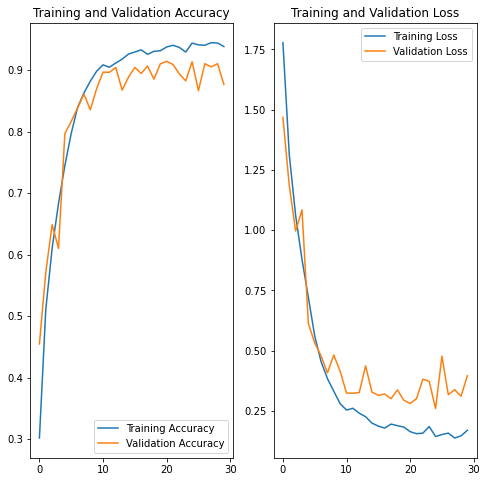

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The rate of increasing of Accuracy for both training and validation;the loss is decreasing at the same rate. hence we can say that the over\underfitting is decreased to a greater extent. Call rebalance has caused this substantial change